In [1]:
##### I. MISE EN PLACE DE L'ENVIRONNEMENT #####

# Installation des modules #
import os
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import ttk, messagebox
import matplotlib.pyplot as plt
from fredapi import Fred
from scipy import interpolate
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

# Forcage du bon dossier 
project_path = r"C:\Users\siham\OneDrive\Documents\M1\S2\PYTHON"
os.chdir(project_path)


=== US YIELD CURVE ===
   Maturity  Rate
0        1M  4.37
1        3M  4.34
2        6M  4.27
3        1Y  4.06
4        2Y  3.97
5        3Y  3.96
6        5Y  4.04
7        7Y  4.16
8       10Y  4.28
9       20Y  4.63
10      30Y  4.60
Le fichier CSV existe déjà à : C:/Users/siham/OneDrive/Documents/M1/S2/PYTHON/US_Yield_Curve.csv


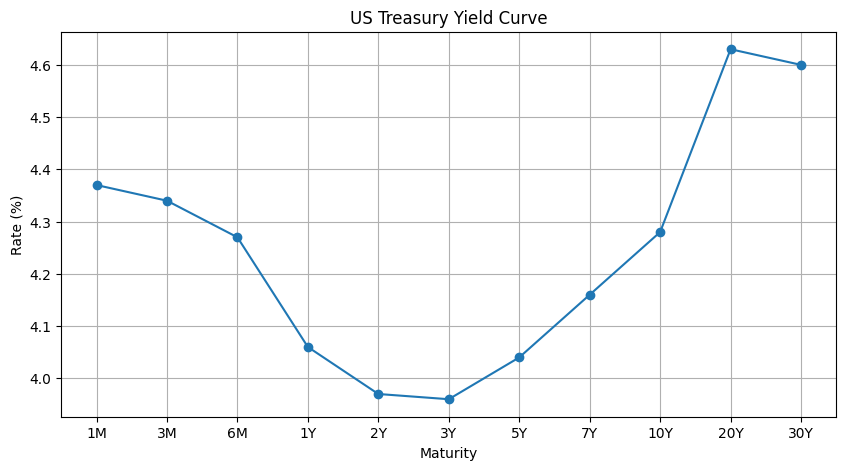

In [2]:
##### II. BASE DE DONNEES #####

## A. US YIELD CURVE ##
# FRED API key : ce6755615bc789593ab6aed48597ea81

fred = Fred(api_key='ce6755615bc789593ab6aed48597ea81') 

# Dictionnaire des maturités & codes FRED correspondants
series_ids = {
    '1M': 'GS1M',
    '3M': 'GS3M',
    '6M': 'GS6M',
    '1Y': 'GS1',
    '2Y': 'GS2',
    '3Y': 'GS3',
    '5Y': 'GS5',
    '7Y': 'GS7',
    '10Y': 'GS10',
    '20Y': 'GS20',
    '30Y': 'GS30'
}

# Récupération des derniers taux disponibles
rates = {}
for label, code in series_ids.items():
    try:
        rates[label] = fred.get_series(code).dropna().iloc[-1]
    except Exception as e:
        print(f"Erreur pour {label} ({code}) : {e}")

# Construction d’un DataFrame
df = pd.DataFrame(rates.items(), columns=['Maturity', 'Rate'])  # Sépare bien Maturity et Rate
df['Rate'] = df['Rate'].round(2)

print("=== US YIELD CURVE ===")
print(df)

# Chemin du fichier CSV
csv_path = "C:/Users/siham/OneDrive/Documents/M1/S2/PYTHON/US_Yield_Curve.csv"

# Vérification si le fichier existe déjà
if not os.path.exists(csv_path):
    # Sauvegarde dans un fichier CSV si il n'existe pas
    df.to_csv(csv_path, index=False, sep=',')  
    print(f"Le fichier CSV n'existait pas, il a été créé à : {csv_path}")
else:
    print(f"Le fichier CSV existe déjà à : {csv_path}")

# Affichage graphique
plt.figure(figsize=(10, 5))
plt.plot(df['Maturity'], df['Rate'], marker='o', linestyle='-')
plt.title("US Treasury Yield Curve")
plt.xlabel("Maturity")
plt.ylabel("Rate (%)")
plt.grid(True)
plt.show()


Le fichier existe déjà. Aucun besoin de scraper à nouveau.

Tableau des taux interpolés depuis le fichier CSV :
    Maturity  Interpolated_Rate_2025
0       1.00                1.938000
1       1.25                1.919250
2       1.50                1.900500
3       2.00                1.863000
4       3.00                1.939000
5       4.00                2.027500
6       5.00                2.116000
7       6.00                2.187000
8       7.00                2.258000
9       8.00                2.311667
10      9.00                2.365333
11     10.00                2.419000
12     11.00                2.446200
13     12.00                2.473400
14     15.00                2.555000
15     20.00                2.500667
16     25.00                2.446333
17     30.00                2.392000
18     40.00                2.283333
19     50.00                2.174667

Affichage du graphique :


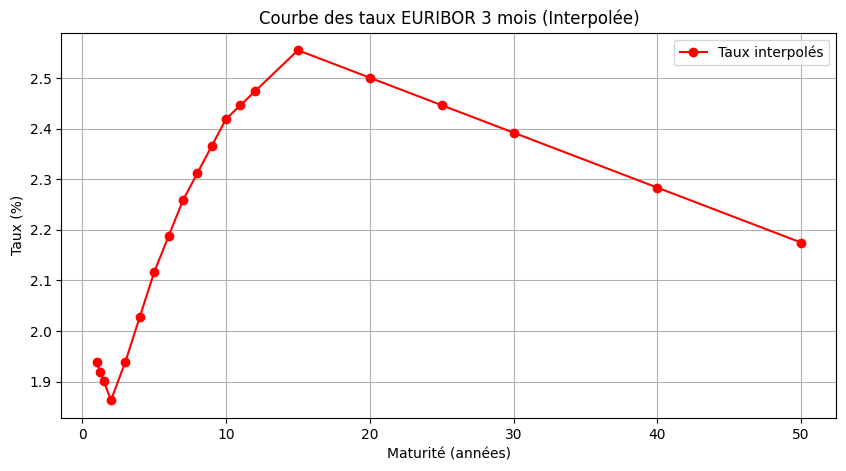

In [3]:
## B. EURIBOR 3M CURVE ##

# Vérifier si le fichier existe déjà
csv_file = "euribor_rates_interpolated.csv"
if not os.path.exists(csv_file):  # Si le fichier n'existe pas, on exécute le code pour scraper et créer le CSV
    print("Le fichier n'existe pas. Début de l'extraction et de l'interpolation des données...")

    # Lancer le driver Selenium
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

    # URL de la page à scraper
    url = 'https://www.chathamfinancial.com/technology/european-market-rates'

    # Ouverture de la page dans un navigateur avec Selenium
    driver.get(url)

    # Attente de 5 secondes pour s'assurer que la page est bien chargée
    time.sleep(5)

    # Récupération du contenu de la page une fois que la page est chargée
    try:
        # Utilisation de BeautifulSoup pour analyser le HTML
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Trouver tous les tableaux sur la page
        tables = soup.find_all('table')

        # Vérification si la page contient au moins 4 tableaux (on veut récupérer le 4ème)
        if len(tables) >= 4:
            # Extraction du 4ème tableau (index 3)
            table = tables[3]

            # Extraction des lignes du tableau
            rows = table.find_all('tr')

            # Initialisation des listes pour les données
            maturities = []
            rates_2025 = []

            # Extraction des données de chaque ligne du tableau
            for row in rows[1:]:  # Ignore la première ligne (en-têtes)
                cols = row.find_all('td')
                if len(cols) > 0:
                    maturities.append(cols[0].text.strip())  # La première colonne est la maturité
                    rates_2025.append(cols[1].text.strip())  # Taux pour 2025

            # Création d'un DataFrame avec les colonnes 'Maturity' et 'Rate_2025'
            df = pd.DataFrame({
                'Maturity': maturities,
                'Rate_2025': rates_2025
            })

            # Affichage du DataFrame
            print("Tableau des taux existants :")
            print(df)

            # Interpolation pour ajouter les maturités manquantes
            maturities_existing = [float(m.split()[0]) for m in maturities]  # Convertir maturité en float
            rates_existing = [float(rate.strip('%')) for rate in rates_2025]  # Convertir taux en float et supprimer '%'  

            # Maturités souhaitées
            maturities_to_add = [1, 1.25, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30, 40, 50]

            # Fonction d'interpolation linéaire
            interp_func = interpolate.interp1d(maturities_existing, rates_existing, kind='linear', fill_value="extrapolate")

            # Interpolation pour les nouvelles maturités
            interpolated_rates = interp_func(maturities_to_add)

            # Création d'un DataFrame avec les nouvelles maturités et leurs taux interpolés
            df_interpolated = pd.DataFrame({
                'Maturity': maturities_to_add,
                'Interpolated_Rate_2025': interpolated_rates
            })

            # Affichage du DataFrame interpolé
            print("\nTableau des taux interpolés :")
            print(df_interpolated)

            # Sauvegarde des données dans un fichier CSV
            df_interpolated.to_csv(csv_file, index=False)
            print(f"Les données interpolées ont été sauvegardées à : {csv_file}")

        else:
            print("Moins de 4 tableaux trouvés sur la page.")
    except Exception as e:
        print("Erreur lors de la récupération des données : ", e)

    # Fermer le navigateur après l'extraction des données
    driver.quit()

else:
    print("Le fichier existe déjà. Aucun besoin de scraper à nouveau.")

# Affichage du graphique et du contenu du fichier CSV
if os.path.exists(csv_file):
    # Chargement des données à partir du CSV si le fichier existe déjà
    df_interpolated = pd.read_csv(csv_file)

    # Affichage du DataFrame du fichier CSV
    print("\nTableau des taux interpolés depuis le fichier CSV :")
    print(df_interpolated)

    # Affichage du graphique
    print("\nAffichage du graphique :")
    plt.figure(figsize=(10, 5))
    plt.plot(df_interpolated['Maturity'], df_interpolated['Interpolated_Rate_2025'], 'ro-', label='Taux interpolés')
    plt.title("Courbe des taux EURIBOR 3 mois (Interpolée)")
    plt.xlabel("Maturité (années)")
    plt.ylabel("Taux (%)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [4]:
## C. CDX IG PRICES ##
# Les données proviennent de Bloomberg /!\

# Nom du fichier
filename = "CDX_IG_Prices.csv"

# Vérifier si le fichier existe déjà
if not os.path.exists(filename):
    # Données
    data = {
        "Name": [
            "21st Century Fox America Inc", "Allstate Corp/The", "Apache Corp", "AT&T Inc", "Block Financial LLC",
            "Carnival Corp", "Comcast Corp", "HP Inc", "MetLife Inc", "Xerox Corp"
        ],
        "CDS Ticker": [
            "CNCP1U5 CBIN Curncy", "CALL1U5 CBIN Curncy", "CAPA1U5 CBIN Curncy", "CSBC1U5 CBIN Curncy",
            "CHRB1U5 CBIN Curncy", "CCCL1U5 CBIN Curncy", "CT363688 CBIN Curncy", "CHWP1U5 CBIN Curncy",
            "CMET1U5 CBIN Curncy", "CXRX1U5 CBIN Curncy"
        ],
        "PX_ASK": [32.218, 32.10185, 132.8265, 98.18737, 108.3073, 51.71049, 46.48309, 53.44293, 72.10919, 220.357],
        "PX_MID": [29.79745, 29.41297, 127.8265, 95.54818, 102.5799, 49.20801, 43.89484, 50.86313, 69.5786, 210.943],
        "PX_BID": [27.37689, 26.72408, 122.8265, 92.909, 96.85262, 46.70553, 41.30658, 48.28332, 67.048, 201.529],
        "Price Eqty Ticker": [
            "FOXA US Equity", "ALL US Equity", "APA US Equity", "T US Equity", "HRB US Equity",
            "CCL US Equity", "CMCSA US Equity", "HPQ US Equity", "MET US Equity", "XRX US Equity"
        ],
        "Eqty Price": [50.44, 94.07, 33.00, 30.419, 24.07, 58.24, 37.8226, 23.23, 44.705, 30.59],
        "6M": [3.2, 8.7, 9.7, 5, 8.6, 9.2, 4.5, 6.1, 6.9, 24.7],
        "1Y": [5.3, 13, 15.9, 6.7, 13.1, 10.3, 8.8, 9.4, 10.9, 32.1],
        "2Y": [9.3, 22, 24, 9.8, 22, 18, 16, 18, 22, 53],
        "3Y": [14.5, 43.7, 33.6, 15.2, 44.6, 26.5, 22.6, 30.8, 34.5, 89.5],
        "4Y": [19.7, 69.9, 44, 20, 69.8, 38.4, 32.5, 44.7, 49.3, 128.3],
        "5Y": [30.4, 109, 54, 27.5, 106, 49, 46.3, 65.5, 66.3, 221],
        "7Y": [38.2, 141.7, 72.5, 39.4, 140.1, 77.1, 68, 87.8, 100.3, 307.9],
        "10Y": [45.1, 170.3, 87.9, 48.7, 158.9, 90.9, 82.7, 108.5, 119.1, 343.6]
    }

    # Création du DataFrame
    df = pd.DataFrame(data)

    # Sauvegarde au format CSV
    df.to_csv(filename, index=False)
    print(f"Fichier '{filename}' créé avec succès.")
else:
    print(f"Le fichier '{filename}' existe déjà. Création non nécessaire.")


Le fichier 'CDX_IG_Prices.csv' existe déjà. Création non nécessaire.


In [5]:
##### III. CODE #####

def convert_maturity_to_float(maturity):
# ------------------------------------------------------------------------------
# Objectif : Convertir une maturité exprimée en chaîne de caractères ("1Y", "6M")
#            en un nombre flottant représentant le nombre d'années.
#            Exemple : "6M" devient 0.5 et "5Y" devient 5.0.
# Entrée : maturity (str ou float) - La maturité sous forme de chaîne ou de nombre.
# Sortie : float - La maturité exprimée en années (nombre flottant).
# ----------------------------------------------------------------------
    if isinstance(maturity, str):
        if 'Y' in maturity:
            return float(maturity.replace('Y', ''))
        elif 'M' in maturity:
            return float(maturity.replace('M', '')) / 12
    return float(maturity)


In [6]:
## A. INTERPOLATION LINEAIRE ##

class cMod_Curve:
# ------------------------------------------------------------------------------
# Objectif : Représente une courbe de taux (Risk-Free, Spread, Libor).
#             Elle stocke les paires (maturité, taux) sous forme d'un dictionnaire
#             et permet d'interpoler linéairement un taux pour une maturité donnée.
#
# Attributs :
#     - dict_Rates : dictionnaire {maturité (float) : taux (float)}
#
# Méthodes :
#     - set_rates(rates) : Remplit le dictionnaire de taux.
#     - fn_Interpolate(dbl_maturity) : 
#           Renvoie le taux associé à une maturité donnée par interpolation linéaire.
# ------------------------------------------------------------------------------
    def __init__(self):
        self.dict_Rates = {}

    def set_rates(self, rates):
        self.dict_Rates = rates

    def fn_Interpolate(self, dbl_maturity):
        dbl_maturity = float(dbl_maturity)
        keys = sorted(self.dict_Rates.keys())

        if dbl_maturity in self.dict_Rates:
            return self.dict_Rates[dbl_maturity]

        for j in range(len(keys)):
            if keys[j] >= dbl_maturity:
                if j == 0:
                    return self.dict_Rates[keys[0]]
                else:
                    x1 = keys[j-1]
                    x2 = keys[j]
                    y1 = self.dict_Rates[x1]
                    y2 = self.dict_Rates[x2]
                    return y1 + (dbl_maturity - x1) * (y2 - y1) / (x2 - x1)

        return self.dict_Rates[keys[-1]]



In [7]:
## B. PRIX, DURATION ET CALENDRIER DES FLUX DE TRESORERIE ##

class cMod_Bond:
# ------------------------------------------------------------------------------
# Objectif : Représente une obligation d'entreprise.
#             Cette classe permet de calculer :
#             - Le prix de l'obligation (en actualisant les flux futurs)
#             - La duration (sensibilité du prix à une variation des taux)
#             - Le calendrier des flux de trésorerie ("schedule")
#
# Attributs :
#     - issuer : Nom de l'émetteur
#     - coupon_rate : Taux facial du coupon
#     - margin : Marge pour les coupons variables
#     - coupon_type : "Fixed" ou "Variable"
#     - coupon_frequency : "Annual", "Semi-Annual" ou "Quarterly"
#     - maturity : Maturité de l'obligation (en années)
#     - spread, obj_RFRate, obj_Spread, obj_LiborCurve : courbes de taux utilisées
#
# Méthodes principales :
#     - get_coupon_frequency_value() : Renvoie la fréquence de paiement sous forme numérique (1, 2, 4)
#     - fn_FirstCouponPaymentDate() : Calcule la première date de paiement du coupon
#     - fn_price() : Calcule le prix de l'obligation (% du nominal)
#     - fn_duration() : Calcule la duration de l'obligation
#     - get_schedule() : Génère l'échéancier des flux de trésorerie
# ------------------------------------------------------------------------------
    def __init__(self, issuer, coupon_rate, margin, coupon_type, coupon_frequency, maturity, spread, rf_curve, spread_curve, libor_curve):
        self.issuer = issuer
        self.coupon_rate = coupon_rate
        self.margin = margin
        self.coupon_type = coupon_type
        self.coupon_frequency = coupon_frequency
        self.maturity = maturity
        self.spread = spread
        self.obj_RFRate = rf_curve
        self.obj_Spread = spread_curve
        self.obj_LiborCurve = libor_curve

    def get_coupon_frequency_value(self):
        if self.coupon_frequency == "Annual":
            return 1
        elif self.coupon_frequency == "Semi-Annual":
            return 2
        elif self.coupon_frequency == "Quarterly":
            return 4
        else:
            return 1

    def fn_FirstCouponPaymentDate(self):
        if self.maturity < 1:
            self.maturity = 1
        first_coupon = self.maturity - int(self.maturity)
        freq = self.get_coupon_frequency_value()

        if freq == 1:
            first_coupon += 1
        elif freq == 2:
            first_coupon += 0.5
        elif freq == 4:
            first_coupon += 0.25
        else:
            first_coupon += 1

        return first_coupon

    def fn_price(self):
        total_price = 0
        coupon_freq = self.get_coupon_frequency_value()
        first_coupon_date = self.fn_FirstCouponPaymentDate()

        for t in np.arange(first_coupon_date, self.maturity + 1e-8, 1 / coupon_freq):
            rf_rate = self.obj_RFRate.fn_Interpolate(t)
            spread = self.obj_Spread.fn_Interpolate(t)

            if self.coupon_type == "Fixed":
                coupon_rate = self.coupon_rate
            else:
                coupon_rate = self.obj_LiborCurve.fn_Interpolate(t) + self.margin

            if np.isclose(t, self.maturity):
                cash_flow = coupon_rate / coupon_freq + 1
            else:
                cash_flow = coupon_rate / coupon_freq

            total_price += cash_flow * (1 + rf_rate + spread) ** -t

        return total_price * 100

    def fn_duration(self):
        weighted_sum = 0
        bond_price = self.fn_price() / 100
        coupon_freq = self.get_coupon_frequency_value()
        first_coupon_date = self.fn_FirstCouponPaymentDate()

        for t in np.arange(first_coupon_date, self.maturity + 1e-8, 1 / coupon_freq):
            rf_rate = self.obj_RFRate.fn_Interpolate(t)
            spread = self.obj_Spread.fn_Interpolate(t)

            if self.coupon_type == "Fixed":
                coupon_rate = self.coupon_rate
            else:
                coupon_rate = self.obj_LiborCurve.fn_Interpolate(t) + self.margin

            if np.isclose(t, self.maturity):
                cash_flow = coupon_rate / coupon_freq + 1
            else:
                cash_flow = coupon_rate / coupon_freq

            weighted_sum += (cash_flow * t) / ((1 + rf_rate + spread) ** t)

        return weighted_sum / bond_price

    def get_schedule(self):
        schedule_data = []
        first_coupon_date = self.fn_FirstCouponPaymentDate()
        coupon_freq = self.get_coupon_frequency_value()

        for t in np.arange(first_coupon_date, self.maturity + 1e-8, 1 / coupon_freq):
            rf_rate = self.obj_RFRate.fn_Interpolate(t)
            spread = self.obj_Spread.fn_Interpolate(t)

            if self.coupon_type == "Fixed":
                coupon_rate = self.coupon_rate
            else:
                coupon_rate = self.obj_LiborCurve.fn_Interpolate(t) + self.margin

            if np.isclose(t, self.maturity):
                cash_flow = coupon_rate / coupon_freq + 1
            else:
                cash_flow = coupon_rate / coupon_freq

            discount_factor = (1 + rf_rate + spread) ** -t
            discounted_cash_flow = cash_flow * discount_factor

            schedule_data.append({
                'Date': round(t, 6),
                'Cash Flow': f"{cash_flow * 100:.4f}%",
                'Risk Free Rate': f"{rf_rate * 100:.4f}%",
                'Spread': f"{spread * 100:.4f}%",
                'Discount Factor': f"{discount_factor * 100:.4f}%",
                'Discounted Cash Flow': f"{discounted_cash_flow * 100:.4f}%"
            })

        return pd.DataFrame(schedule_data)


In [8]:
## C. NOTRE OUTIL : LE PRICER ##

def load_data():
# ------------------------------------------------------------------------------
# Objectif : Charger les données de taux depuis les fichiers CSV :
#             - Libor 3M interpolé
#             - US Yield Curve
#             - CDX IG Prices (spreads)
# Retourne :
#     - dict_LIBOR3M : Dictionnaire des taux Libor 3M
#     - dict_US_YIELD_CURVE : Dictionnaire des taux US Risk-Free
#     - cdx_ig_prices : Table complète des spreads par entreprise
# ------------------------------------------------------------------------------
    libor_curve = pd.read_csv('euribor_rates_interpolated.csv')
    us_yield_curve = pd.read_csv('US_Yield_Curve.csv')
    cdx_ig_prices = pd.read_csv('CDX_IG_Prices.csv')

    dict_LIBOR3M = {convert_maturity_to_float(maturity): rate / 100 for maturity, rate in zip(libor_curve['Maturity'], libor_curve['Interpolated_Rate_2025'])}
    dict_US_YIELD_CURVE = {convert_maturity_to_float(maturity): rate / 100 for maturity, rate in zip(us_yield_curve['Maturity'], us_yield_curve['Rate'])}

    return dict_LIBOR3M, dict_US_YIELD_CURVE, cdx_ig_prices


In [9]:
## D. L'INTERFACE DU PRICER  ##

def sub_pricer(issuer, coupon_rate, margin, coupon_type, coupon_frequency, maturity):
# ------------------------------------------------------------------------------
# Objectif : 
#     - Créer les objets de courbes (Libor, Risk-Free, Spread) selon l'émetteur sélectionné
#     - Instancier l'obligation
#     - Calculer le prix, la duration et générer l'échéancier des cash flows
# Entrées :
#     - issuer : entreprise sélectionnée
#     - coupon_rate : taux du coupon
#     - margin : marge si coupon variable
#     - coupon_type : "Fixed" ou "Variable"
#     - coupon_frequency : "Annual", "Semi-Annual", "Quarterly"
#     - maturity : maturité de l'obligation
# Retourne :
#     - price : prix de l'obligation (% du nominal)
#     - duration : duration de l'obligation (en années)
#     - schedule : DataFrame avec le calendrier des flux
# ------------------------------------------------------------------------------
    dict_LIBOR3M, dict_US_YIELD_CURVE, cdx_ig_prices = load_data()

    issuer_row = cdx_ig_prices[cdx_ig_prices['Name'] == issuer]
    if issuer_row.empty:
        raise ValueError(f"Issuer {issuer} not found in CDX_IG_Prices.csv")

    dict_Spreads = {
        convert_maturity_to_float('0.5Y'): issuer_row['6M'].values[0] / 10000,
        convert_maturity_to_float('1Y'): issuer_row['1Y'].values[0] / 10000,
        convert_maturity_to_float('2Y'): issuer_row['2Y'].values[0] / 10000,
        convert_maturity_to_float('3Y'): issuer_row['3Y'].values[0] / 10000,
        convert_maturity_to_float('4Y'): issuer_row['4Y'].values[0] / 10000,
        convert_maturity_to_float('5Y'): issuer_row['5Y'].values[0] / 10000,
        convert_maturity_to_float('7Y'): issuer_row['7Y'].values[0] / 10000,
        convert_maturity_to_float('10Y'): issuer_row['10Y'].values[0] / 10000
    }

    obj_LIBOR3M = cMod_Curve()
    obj_US_YIELD_CURVE = cMod_Curve()
    obj_Spread = cMod_Curve()

    obj_LIBOR3M.set_rates(dict_LIBOR3M)
    obj_US_YIELD_CURVE.set_rates(dict_US_YIELD_CURVE)
    obj_Spread.set_rates(dict_Spreads)

    company_bond = cMod_Bond(
        issuer, coupon_rate, margin, coupon_type, coupon_frequency, maturity,
        obj_Spread, obj_US_YIELD_CURVE, obj_Spread, obj_LIBOR3M
    )

    price = company_bond.fn_price()
    duration = company_bond.fn_duration()
    schedule = company_bond.get_schedule()

    return price, duration, schedule


In [10]:
def run_interface():
# ------------------------------------------------------------------------------
# Fonction : run_interface()
# Objectif : Lancer une interface graphique Tkinter pour permettre à l'utilisateur de :
#             - Choisir les paramètres de l'obligation (émetteur, taux, maturité, etc.)
#             - Calculer le prix et la duration
#             - Afficher dynamiquement le calendrier de flux
# Résultat : L'interface Tkinter est lancée et interactive
# ------------------------------------------------------------------------------
    def calculate():
    # ------------------------------------------------------------------------------
    # Fonction interne : calculate()
    # Objectif : (Appelée par le bouton Tkinter)
    #             - Récupérer les inputs utilisateur
    #             - Lancer le pricer
    #             - Afficher le prix, la duration et le calendrier dans l'interface
    # ------------------------------------------------------------------------------
        try:
            # Clear the Treeview
            for item in schedule_tree.get_children():
                schedule_tree.delete(item)

            # Retrieve user inputs
            issuer = issuer_combo.get()
            coupon_type = type_combo.get()
            coupon_frequency = freq_combo.get()
            coupon_rate = float(coupon_rate_entry.get())
            margin = float(margin_entry.get())
            maturity = float(maturity_entry.get())

            # Pricing
            price, duration, schedule_df = sub_pricer(
                issuer, coupon_rate, margin, coupon_type, coupon_frequency, maturity
            )

            # Display Price and Duration
            result_label.config(text=f"Price: {round(price, 6)} %\nDuration: {round(duration, 6)} years")

            # Fill Treeview with Schedule
            for _, row in schedule_df.iterrows():
                schedule_tree.insert('', 'end', values=list(row))

        except Exception as e:
            messagebox.showerror("Error", str(e))

    window = tk.Tk()
    window.title("Corporate Bond Pricer")

    # List values
    list_issuers = [
        "21st Century Fox America Inc", "Allstate Corp/The", "Apache Corp", "AT&T Inc",
        "Block Financial LLC", "Carnival Corp", "Comcast Corp", "HP Inc", "MetLife Inc", "Xerox Corp"
    ]
    list_coupon_types = ["Fixed", "Variable"]
    list_coupon_frequencies = ["Annual", "Semi-Annual", "Quarterly"]

    # Inputs
    tk.Label(window, text="Issuer").pack()
    issuer_combo = ttk.Combobox(window, values=list_issuers, width=50)
    issuer_combo.pack()

    tk.Label(window, text="Coupon Type").pack()
    type_combo = ttk.Combobox(window, values=list_coupon_types)
    type_combo.pack()

    tk.Label(window, text="Coupon Frequency").pack()
    freq_combo = ttk.Combobox(window, values=list_coupon_frequencies)
    freq_combo.pack()

    tk.Label(window, text="Coupon Rate (e.g., 0.05)").pack()
    coupon_rate_entry = tk.Entry(window)
    coupon_rate_entry.pack()

    tk.Label(window, text="Margin (if Variable, else 0)").pack()
    margin_entry = tk.Entry(window)
    margin_entry.pack()

    tk.Label(window, text="Maturity (e.g., 5.5)").pack()
    maturity_entry = tk.Entry(window)
    maturity_entry.pack()

    # Button
    tk.Button(window, text="Calculate", command=calculate).pack(pady=10)

    # Results
    result_label = tk.Label(window, text="", font=("Arial", 12))
    result_label.pack()

    # Schedule Table
    schedule_frame = tk.Frame(window)
    schedule_frame.pack(pady=10)

    schedule_tree = ttk.Treeview(schedule_frame, columns=("Date", "Cash Flow", "Risk Free Rate", "Spread", "Discount Factor", "Discounted Cash Flow"), show="headings")
    schedule_tree.pack(side="left", fill="both", expand=True)

    for col in schedule_tree["columns"]:
        schedule_tree.heading(col, text=col)
        schedule_tree.column(col, anchor="center", width=120)

    scrollbar = ttk.Scrollbar(schedule_frame, orient="vertical", command=schedule_tree.yview)
    schedule_tree.configure(yscrollcommand=scrollbar.set)
    scrollbar.pack(side="right", fill="y")

    window.mainloop()

if __name__ == "__main__":
    run_interface()
